# Building RAG Chatbots for Technical Documentation - First Experimental Approach (**Part 2**)

`(1) LangSmith`

https://docs.smith.langchain.com/ (To generate an API Key) <br><br>
Copy your token into the **HFHUB_API_KEY** parameter in the **Constants.py** file.

In [1]:
import os
import Constants
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = Constants.LANGCHAIN_API_KEY

`(2) HuggingFace API Key`

https://huggingface.co/settings/tokens

- Press **+ Create new Token**
<br><br>
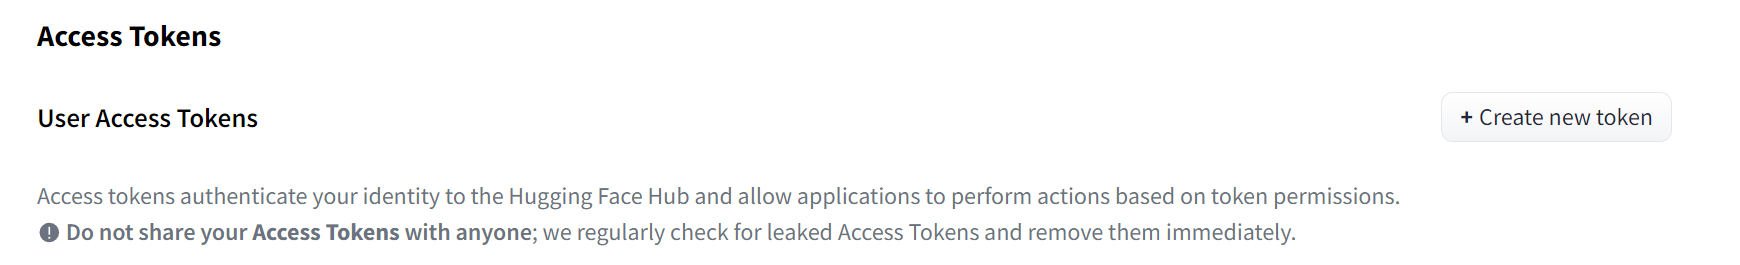
<br><br>
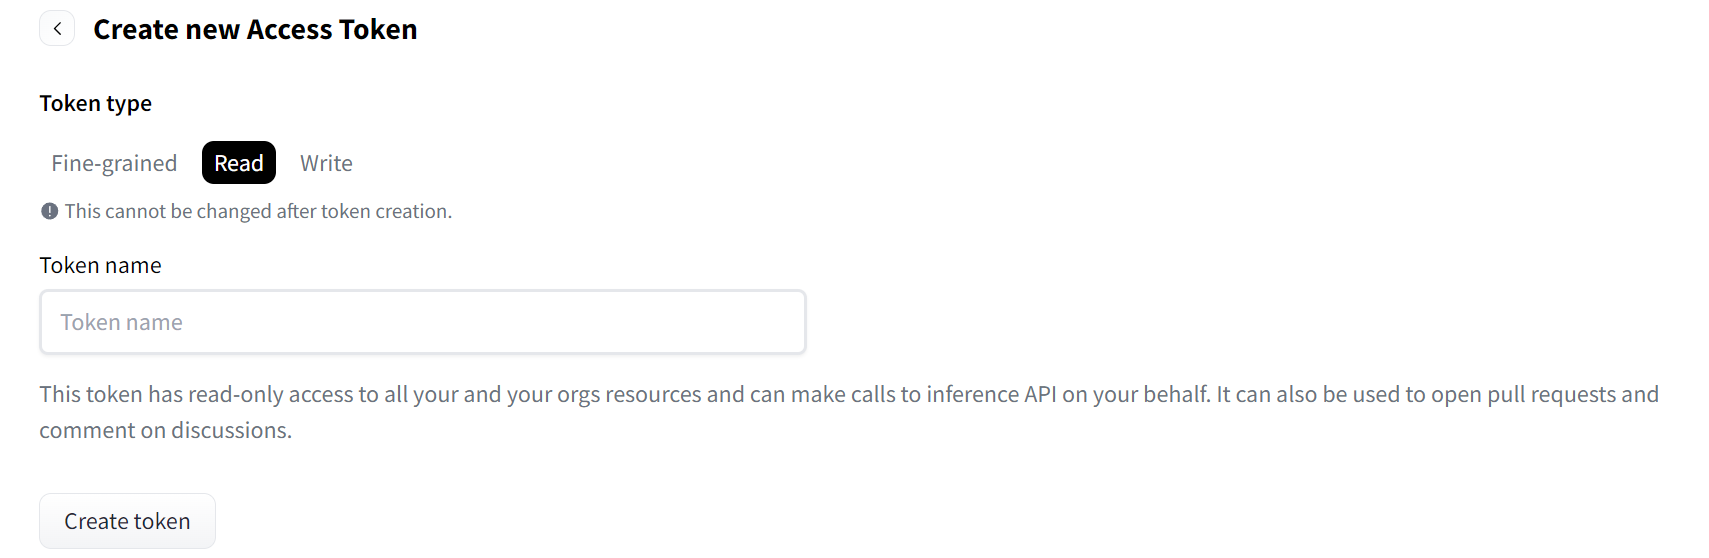
<br><br>
- Choose a name and you token is created.<br><br>
- Copy your token into the **HFHUB_API_KEY** parameter in the **Constants.py** file.

In [2]:
HFHUB_API_KEY = Constants.HFHUB_API_KEY

In [3]:
from langchain import hub
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.llms import HuggingFaceHub
from langchain_chroma import Chroma


## Part 3 : Generate Retreiver

In [4]:
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    model_kwargs={'tokenizer_kwargs': {'clean_up_tokenization_spaces': True}} # clean up extra spaces around special tokens
)
vectorstore = Chroma(persist_directory=Constants.PERSIST_DIRECTORY, embedding_function=embeddings)
retriever = vectorstore.as_retriever()


C:\Users\tomas\AppData\Local\Temp\ipykernel_34272\2178116513.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
c:\Users\tomas\Anaconda3\envs\taac_req\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Part 4 : Initialize the LLM and prompt template

In [5]:
from langchain_core.prompts import ChatPromptTemplate
# Prompt
#prompt = hub.pull("rlm/rag-prompt")
template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

**Question**: {question} 

**Context**: {context} 

**Provide your answer**: """

prompt = ChatPromptTemplate.from_template(template)
# LLM
# Corrected HuggingFaceEndpoint initialization
llm = HuggingFaceHub(repo_id="meta-llama/Llama-3.2-3B-Instruct", 
                     model_kwargs={"temperature": 0.6, "max_length": 510},
                     huggingfacehub_api_token=HFHUB_API_KEY)


C:\Users\tomas\AppData\Local\Temp\ipykernel_34272\3442260151.py:15: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  llm = HuggingFaceHub(repo_id="meta-llama/Llama-3.2-3B-Instruct",


## Part 5 : Define RAG Chain

In [6]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

## Part 6 : Invoke RAG Chain

In [7]:
import re

def extract_provide_answer(text):
    # Pattern to find the text following "Provide your answer:"
    pattern = r"\*\*Provide your answer\*\*\s*:\s*(.*?)(?=\*\*|$)"

    # Search for the pattern in the text
    match = re.search(pattern, text, re.DOTALL)
    
    # Return the matched text, stripping any leading/trailing whitespace
    return match.group(1).strip() if match else None

def extract_context(text):
    # Pattern to find the text between "Context:" and "Provide your answer:"
    pattern = r"\*\*Context\*\*\s*(.*?)\*\*Provide your answer\*\*"
    
    # Search for the pattern in the text
    match = re.search(pattern, text, re.DOTALL)
    
    # Return the matched text, stripping any leading/trailing whitespace
    return match.group(1).strip() if match else None

In [8]:
# Question
result = rag_chain.invoke("What are the key requirements for high-risk AI systems under the AI Act?")

In [9]:
print(extract_provide_answer(result))

I don't know.


In [10]:
print(extract_context(result))

: 02017R0745 — EN — 09.07.2024 — 004.001 — 127  
ANNEX I  
GENERAL SAFETY AND PERFORMANCE REQUIREMENTS  
CHAPTER I  
GENERAL REQUIREMENTS  
1. Devices shall achieve the performance intended by their manu facturer 
and shall be designed and manufactured in such a way that, duri ng 
normal conditions of use, they are suitable for their intended purpose. 
They shall be safe and effective and shall not compromise the c linical 
condition or the safety of patients, or the safety and health o f users or, 
where applicable, other persons, provided that any risks which may be 
associated with their use constitute acceptable risks when weig hed 
against the benefits to the patient and are compatible with a h igh level 
of protection of health and safety, taking into account the gen erally 
acknowledged state of the art.  
2. The requirement in this Annex to reduce risks as far as poss ible means 
the reduction of risks as far as possible without adversely aff ecting the 
benefit-risk ratio.

(d

# RAGAS

In [18]:
from datasets import Dataset
from deepeval import evaluate
from deepeval.metrics import AnswerRelevancyMetric, FaithfulnessMetric

In [ ]:
from datasets import Dataset

questions = [
    "What is the main objective of the AI Act?",
    "What are the key requirements for high-risk AI systems under the AI Act?",
    "How does the AI Act address the issue of transparency in AI systems?",
    "What obligations do providers of AI systems have under the AI Act?",
    "How does the AI Act ensure the protection of fundamental rights?",
    "What are the penalties for non-compliance with the AI Act?",
    "What role do national competent authorities play in the AI Act?",
    "How does the AI Act define 'high-risk AI systems'?",
    "What measures are required for the post-market monitoring of AI systems?",
    "How does the AI Act address the issue of bias in AI systems?"
]

ground_truths = [
    ["The main objective of the AI Act is to ensure that AI systems placed on the market or put into service in the Union are safe and respect existing law on fundamental rights and Union values."],
    ["High-risk AI systems must comply with requirements related to risk management, data governance, technical documentation, record-keeping, transparency, human oversight, accuracy, robustness, and cybersecurity."],
    ["The AI Act requires that AI systems be designed and developed in a way that ensures transparency, including providing clear information to users about the capabilities and limitations of the AI system."],
    ["Providers of AI systems must ensure that their systems comply with the requirements of the AI Act, conduct conformity assessments, and implement quality management systems."],
    ["The AI Act ensures the protection of fundamental rights by imposing strict requirements on high-risk AI systems and prohibiting certain AI practices that are deemed to be unacceptable."],
    ["Penalties for non-compliance with the AI Act can include fines of up to 6% of the total worldwide annual turnover of the preceding financial year or €30 million, whichever is higher."],
    ["National competent authorities are responsible for the supervision and enforcement of the AI Act, including conducting market surveillance and ensuring compliance with the requirements."],
    ["High-risk AI systems are defined as those that pose a significant risk to the health, safety, or fundamental rights of persons, including AI systems used in critical infrastructure, education, employment, and law enforcement."],
    ["Post-market monitoring measures include the obligation for providers to collect, document, and analyze data on the performance of AI systems throughout their lifecycle to ensure ongoing compliance with the AI Act."],
    ["The AI Act addresses bias by requiring that AI systems be designed and developed in a way that ensures fairness and prevents discriminatory outcomes."]
]

answers = []
contexts = []

# Inference
for query in questions:
  result = rag_chain.invoke(query)
  answers.append(extract_provide_answer(result))
  contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])

# To dict
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truths": ground_truths
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

In [20]:
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truths": ground_truths
}

# Convert dictionary to dataset
dataset = Dataset.from_dict(data)

In [ ]:
mwetric = AnswerRelevancyMetric()